# Clustering Analysis for Toronto

Importing all packages needed

In [1]:
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # !conda install -c conda-forge folium=0.5.0  -- Run this if import throws Module error
import requests
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
neighborhoods=pd.read_excel('Toronto_neighborhood_info_w_latlon.xlsx',index_col=0).sort_values('PostalCode').reset_index(drop=True)
neighborhoods.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [3]:
print("DataFrame has",neighborhoods.Borough.nunique(),"boroughs and",neighborhoods.Neighborhood.nunique(),'neighborhoods.')

DataFrame has 10 boroughs and 98 neighborhoods.


Fetching geo information of toronto

In [4]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Map of Toronto with all boroughs

In [5]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Subsetting data for only boroughs containing toronto in their name 

In [6]:
selected_data = neighborhoods[neighborhoods['Borough'].str.contains('Toronto')].reset_index(drop=True)
selected_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


Visualizing map for all boroughs having Toronto in their name

In [7]:
map_of_toronto = folium.Map(location = [latitude, longitude], zoom_start = 11)

for borough, neighborhood, latitude, longitude in zip(selected_data['Borough'], 
                                                      selected_data['Neighborhood'], 
                                                      selected_data['Latitude'], 
                                                      selected_data['Longitude']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_of_toronto)  
    
map_of_toronto

Declaring connection information

In [8]:
CLIENT_ID = '1I0M5B0NXVLPVII3FTDISTSKGXQ4A2PQ0DBHDJWUNFPQGFUB' # your Foursquare ID
CLIENT_SECRET = '100A5F4F1EZNFWNA1J31EOMIXPYYZSTJYCBEWP2WYRPK5VNY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1I0M5B0NXVLPVII3FTDISTSKGXQ4A2PQ0DBHDJWUNFPQGFUB
CLIENT_SECRET:100A5F4F1EZNFWNA1J31EOMIXPYYZSTJYCBEWP2WYRPK5VNY


In [9]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
RADIUS = 500 # defined radius as 500m

## Initial analysis for a single neighborhood 

In [10]:
print("The neighborhood I'll explore is:",selected_data['Neighborhood'][0])

The neighborhood I'll explore is: The Beaches


In [11]:
neighborhood_name = selected_data['Neighborhood'][0]
neighborhood_latitude = selected_data['Latitude'][0]
neighborhood_longitude = selected_data['Longitude'][0]
print('Latitude and longitude values of ',neighborhood_name,'are',neighborhood_latitude,',',neighborhood_longitude,'.')

Latitude and longitude values of  The Beaches are 43.67635739999999 , -79.2930312 .


In [12]:
url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
       '&client_secret={}&v={}&ll={},{}&radius={}&limit={}').format(CLIENT_ID, 
                                                                  CLIENT_SECRET, 
                                                                  VERSION, 
                                                                  neighborhood_latitude, 
                                                                  neighborhood_longitude, 
                                                                  RADIUS,
                                                                  LIMIT)
result = requests.get(url).json()

In [13]:
def fetch_category_info(row):
    try:
        categories_info = row['categories']
    except:
        categories_info = row['venue.categories']
        
    if len(categories_info) == 0:
        return None
    else:
        return categories_info[0]['name']

In [14]:
venues = result['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)

# Filter the columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# Filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(fetch_category_info, axis = 1)

# Clean all column names
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Glen Manor Ravine,Trail,43.676821,-79.293942
1,The Big Carrot Natural Food Market,Health Food Store,43.678879,-79.297734
2,Grover Pub and Grub,Pub,43.679181,-79.297215
3,Upper Beaches,Neighborhood,43.680563,-79.292869


In [15]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


## Fetching venues for all neighborhoods involved 

In [16]:
def getNearbyVenues(names, latitudes, longitudes, RADIUS):
    
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            RADIUS, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
list_of_venues = getNearbyVenues(selected_data['Neighborhood'],selected_data['Latitude'],selected_data['Longitude'],RADIUS)

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High Park, The Junction South
Parkdale, Roncesvalles
Runnymede, Swansea
Queen's

In [18]:
list_of_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,56,56,56,56,56,56
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
Business reply mail Processing CentrE,18,18,18,18,18,18
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst",16,16,16,16,16,16
Central Bay Street,64,64,64,64,64,64
Christie,18,18,18,18,18,18
Church and Wellesley,75,75,75,75,75,75
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,32,32,32,32,32,32


In [19]:
print('There are {} uniques categories.'.format(len(list_of_venues['Venue Category'].unique())))

There are 227 uniques categories.


## Neighborhood Analysis 

Forming different clusters and analysing why thet are different 

In [20]:
toronto_onehot = pd.get_dummies(list_of_venues[['Venue Category']], prefix = "", prefix_sep = "")
toronto_onehot = pd.concat([list_of_venues['Neighborhood'], toronto_onehot.drop(['Neighborhood'], axis = 1)], axis = 1)
toronto_onehot.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [21]:
toronto_onehot.shape

(1635, 227)

In [22]:
toronto_grouped = toronto_onehot.groupby(['Neighborhood']).mean().reset_index()
toronto_grouped

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,0.017857,0.000000,0.000000,0.000000,0.000000,0.017857,0.000000,0.017857,0.035714,0.000000,0.000000,0.00,0.017857,0.017857,0.000000,0.035714,0.000000,0.000000,0.017857,0.000000,0.0000,0.000000,0.000000,0.00,0.017857,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.017857,0.035714,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.053571,0.000000,0.00000,0.00000,0.000000,0.00,0.00,0.017857,0.000000,0.017857,0.000000,0.017857,0.000,0.017857,0.000000,0.000000,0.000000,0.000000,0.017857,0.000000,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.017857,0.000000,0.00,0.000000,0.000000,0.035714,0.000000,0.000000,0.000

In [23]:
toronto_grouped.shape

(39, 227)

In [24]:
num_top_venues = 5
for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.05
1          Restaurant  0.04
2                Café  0.04
3         Cheese Shop  0.04
4  Italian Restaurant  0.04


----Brockton, Parkdale Village, Exhibition Place----
                venue  freq
0                Café  0.13
1         Coffee Shop  0.09
2      Breakfast Spot  0.09
3         Yoga Studio  0.04
4  Italian Restaurant  0.04


----Business reply mail Processing CentrE----
                venue  freq
0         Yoga Studio  0.06
1                 Spa  0.06
2       Garden Center  0.06
3              Garden  0.06
4  Light Rail Station  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst----
              venue  freq
0   Airport Service  0.19
1    Airport Lounge  0.12
2  Airport Terminal  0.12
3   Harbor / Marina  0.06
4           Airport  0.06


----Central Bay Street----
                 venue  freq
0          Coffee Shop  0.19
1   Italian Restaurant  0.06
2       Sandwich Pla

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Italian Restaurant,Restaurant,Beer Bar,Café,Cheese Shop,Bakery,Seafood Restaurant,Farmers Market
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Yoga Studio,Bakery,Stadium,Burrito Place,Restaurant,Climbing Gym,Pet Store
2,Business reply mail Processing CentrE,Yoga Studio,Auto Workshop,Park,Comic Shop,Pizza Place,Recording Studio,Restaurant,Burrito Place,Brewery,Light Rail Station
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Boat or Ferry,Harbor / Marina,Boutique,Bar,Plane,Sculpture Garden,Airport
4,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Spa,Japanese Restaurant,Ice Cream Shop,Burger Joint,Gym / Fitness Center,Bubble Tea Shop


## Clustering 

In [30]:
cluster_range = range( 1, 10 )
cluster_distance = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters,random_state=111)
    clusters.fit( toronto_grouped_clustering )
    cluster_distance.append( clusters.inertia_ )
    
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_distance": cluster_distance } )
clusters_df['Percent_distance_change']=((clusters_df.cluster_distance.shift() - clusters_df.cluster_distance)/clusters_df.cluster_distance.shift())*100
clusters_df

,num_clusters,cluster_distance,Percent_distance_change
0,1,3.842807,NaN
1,2,2.854579,25.716297
2,3,2.357904,17.399250
3,4,1.883107,20.136397
4,5,1.695607,9.956948
5,6,1.508111,11.057785
6,7,1.304960,13.470545
7,8,1.144147,12.323194
8,9,1.087097,4.986241


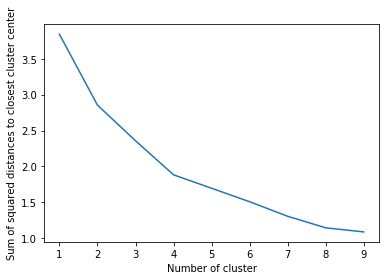

In [31]:
plt.figure()
plt.plot(clusters_df['num_clusters'][0:10], clusters_df['cluster_distance'][0:10])
plt.xlabel("Number of cluster")
plt.ylabel("Sum of squared distances to closest cluster center")
plt.show()

Choosing 4 clusters as the change in distance from 4 to 5 is not that much , we also see a slight bend at 4 in the elbow graph which further supports the argument

In [32]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
cluster_no=4
# Run K-Means clustering
kMeans = KMeans(n_clusters = cluster_no, random_state = 111).fit(toronto_grouped_clustering)

In [33]:
# Add clustering labels
neighborhoods_venues_sorted['Cluster Labels']= kMeans.labels_
neighborhoods_venues_sorted=neighborhoods_venues_sorted.set_index('Cluster Labels').reset_index()

# Combine the data
toronto_merged = selected_data.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on = 'Neighborhood')
toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Trail,Health Food Store,Pub,Yoga Studio,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1,Greek Restaurant,Italian Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Furniture / Home Store,Restaurant,Indian Restaurant,Sports Bar,Pub
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,1,Fast Food Restaurant,Park,Sushi Restaurant,Movie Theater,Pet Store,Pub,Restaurant,Burrito Place,Liquor Store,Sandwich Place
3,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Café,Coffee Shop,Gastropub,Bakery,Brewery,American Restaurant,Seafood Restaurant,Sandwich Place,Cheese Shop,Pet Store
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,3,Park,Swim School,Bus Line,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


Visualizing map with different cluster types

In [34]:
# create map
map_clusters = folium.Map(location = [latitude, longitude], zoom_start = 11)

# set color scheme for the clusters
x = np.arange(cluster_no)
ys = [i + x + (i*x)**2 for i in range(cluster_no)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for neighborhood, cluster, latitude, longitude in zip(toronto_merged['Neighborhood'], toronto_merged['Cluster Labels'], toronto_merged['Latitude'], toronto_merged['Longitude']):
    label = folium.Popup(str(neighborhood) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = rainbow[cluster - 1],
        fill = True,
        fill_color = rainbow[cluster - 1],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters

### Examining each cluster 

In [35]:
# For Cluster 0
result = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
print("For cluster {}, the distribution of venues is as:\n{}".format(0, result['1st Most Common Venue'].value_counts()))
result

For cluster 0, the distribution of venues is as:
Playground    1
Name: 1st Most Common Venue, dtype: int64


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Central Toronto,0,Playground,Tennis Court,Yoga Studio,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


In [36]:
# For Cluster 1
result = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
print("For cluster {}, the distribution of venues is as:\n{}".format(1, result['1st Most Common Venue'].value_counts()))
result

For cluster 1, the distribution of venues is as:
Coffee Shop             13
Café                     5
Sandwich Place           1
Yoga Studio              1
Pizza Place              1
Airport Service          1
Jewelry Store            1
Bakery                   1
Trail                    1
Bar                      1
Gift Shop                1
Mexican Restaurant       1
Hotel                    1
Pub                      1
Grocery Store            1
Fast Food Restaurant     1
Clothing Store           1
Greek Restaurant         1
Dessert Shop             1
Name: 1st Most Common Venue, dtype: int64


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,1,Trail,Health Food Store,Pub,Yoga Studio,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
1,East Toronto,1,Greek Restaurant,Italian Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Furniture / Home Store,Restaurant,Indian Restaurant,Sports Bar,Pub
2,East Toronto,1,Fast Food Restaurant,Park,Sushi Restaurant,Movie Theater,Pet Store,Pub,Restaurant,Burrito Place,Liquor Store,Sandwich Place
3,East Toronto,1,Café,Coffee Shop,Gastropub,Bakery,Brewery,American Restaurant,Seafood Restaurant,Sandwich Place,Cheese Shop,Pet Store
5,Central Toronto,1,Hotel,Department Store,Park,Gym,Breakfast Spot,Convenience Store,Sandwich Place,Food & Drink Shop,Dumpling Restaurant,Donut Shop
6,Central Toronto,1,Clothing Store,Coffee Shop,Yoga Studio,Salon / Barbershop,Restaurant,Rental Car Location,Café,Chinese Restaurant,Pet Store,Miscellaneous Shop
7,Central Toronto,1,Dessert Shop,Pizza Place,Sandwich Place,Gym,Italian Restaurant,Café,Sushi Restaurant,Coffee Shop,Brewery,Restaurant
9,Central Toronto,1,Pub,Coffee Shop,Fried Chicken Joint,Light Rail Station,Liquor Store,Restaurant,Sports Bar,Bank,Supermarket,Bagel Shop
11,Downtown Toronto,1,Coffee Shop,Bakery,Italian Restaurant,Café,Pub,Pizza Place,Restaurant,Chinese Restaurant,Gastropub,Convenience Store
12,Downtown Toronto,1,Coffee Shop,Japanese Restaurant,Gay Bar,Restaurant,Sushi Restaurant,Pub,Café,Gastropub,Hotel,Yoga Studio


In [37]:
# For Cluster 2
result = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
print("For cluster {}, the distribution of venues is as:\n{}".format(2, result['1st Most Common Venue'].value_counts()))
result

For cluster 2, the distribution of venues is as:
Garden    1
Name: 1st Most Common Venue, dtype: int64


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Central Toronto,2,Garden,Yoga Studio,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


In [38]:
# For Cluster 3
result = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
print("For cluster {}, the distribution of venues is as:\n{}".format(3, result['1st Most Common Venue'].value_counts()))
result

For cluster 3, the distribution of venues is as:
Park    2
Name: 1st Most Common Venue, dtype: int64


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Central Toronto,3,Park,Swim School,Bus Line,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
10,Downtown Toronto,3,Park,Playground,Trail,Cupcake Shop,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store


The findings from the analysis are as following: <br><hr>
Cluster 0 : Has playground<br>
Cluster 1 : Mostly has coffee shops<br>
Cluster 2 : Has Garden<br>
Cluster 3 : Has Park